<img title="GitHub Octocat" src='./img/Octocat.jpg' style='height: 60px; padding-right: 15px' alt="Octocat" align="left"> This notebook is part of a GitHub repository: https://github.com/pessini/moby-bikes 
<br>MIT Licensed
<br>Author: Leandro Pessini

<img title="Moby Bikes" src="https://i.ytimg.com/vi/-s8er6tHD3o/maxresdefault.jpg" style="height:400px; border-radius: 10px" alt="Moby Bikes" class="img-fluid">

<div class="list-group" id="list-tab" role="tablist">
  <h1 class="list-group-item list-group-item-action active" data-toggle="list"  role="tab" aria-controls="home">&nbsp;Table of Contents:</h1>
  <a class="list-group-item list-group-item-action" data-toggle="list" href="#1" role="tab" aria-controls="profile">1. Introduction<span class="badge badge-primary badge-pill">1</span></a>
  <a class="list-group-item list-group-item-action" data-toggle="list" href="#2" role="tab" aria-controls="messages">2. Feature Engineering<span class="badge badge-primary badge-pill">2</span></a>
  <a class="list-group-item list-group-item-action" data-toggle="list" href="#3" role="tab" aria-controls="messages">3. EDA (Exploratory Data Analysis)<span class="badge badge-primary badge-pill">3</span></a>
   <a class="list-group-item list-group-item-action" data-toggle="list" href="#4" role="tab" aria-controls="messages">4. Model<span class="badge badge-primary badge-pill">4</span></a>
   <a class="list-group-item list-group-item-action" data-toggle="list" href="#5" role="tab" aria-controls="messages">5. Evaluation<span class="badge badge-primary badge-pill">5</span></a>    
   <a class="list-group-item list-group-item-action" data-toggle="list" href="#6" role="tab" aria-controls="messages">6. Conclusion<span class="badge badge-primary badge-pill">6</span></a>
</div>

---

<a id="1"></a>
# <p style="font-size:100%; text-align:left; color:#444444;">1- Introduction</p>

## Datasets

Dataset provided by [Moby Bikes](https://data.gov.ie/dataset/moby-bikes) through a public [API](https://data.smartdublin.ie/mobybikes-api). 

Dataset provided by [Met Éireann](https://www.met.ie/) through a public [API](https://data.gov.ie/organization/meteireann). 

## Questions

- 


>https://mobidev.biz/blog/machine-learning-methods-demand-forecasting-retail

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm
from scipy import stats
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Models & Evaluation
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn import linear_model
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn import metrics

# Database
from conn import mongodb
import importlib
from pymongo import MongoClient
from urllib.parse import quote_plus
importlib.reload(mongodb)

<module 'conn.mongodb' from '/Users/pessini/Dropbox/Data-Science/moby-bikes/notebooks/conn/mongodb.py'>

In [2]:
def _connect_mongo(host, port, username, password, db_name):
    """ A util for making a connection to mongo """

    if username and password:
        try:
            mongo_uri = f'mongodb://{username}:{quote_plus(password)}@{host}:{port}/{db_name}'
            conn = MongoClient(mongo_uri)
        except:
            print('Could not connect to MongoDB')
    else:
        conn = MongoClient(host, port)

    return conn

In [3]:
def read_mongo(query={}, collection='', no_id=True):
    """ Read from Mongo and Store into a DataFrame """
    df = None
    try:
        # Connect to MongoDB
        conn = _connect_mongo(host=mongodb.host, port=mongodb.port, username=mongodb.user_name, password=mongodb.pass_word, db_name=mongodb.db_name)
        db = conn.mobybikes # switch to the database

        if collection in db.list_collection_names():
            
            # Make a query to the specific DB and Collection and store into a Dataframe
            data = db[collection].find(query)
            df =  pd.DataFrame(list(data))
            
            # Delete the _id
            if no_id:
                del df['_id']
        else:
            print(f'Collection {collection} was not found!')
            pass

        # close mongodb connection
        conn.close()
    except:
        print('Could not query MongoDB')
    
    return df


In [4]:
# from bson.objectid import ObjectId

# query = {
#     '_id': ObjectId('')
# }

historical_data = read_mongo(collection='historical')

In [5]:
historical_data.columns = historical_data.columns.str.lower()
historical_data.head()

,harvesttime,bikeid,battery,bikeidentifier,biketypename,ebikeprofileid,ebikestateid,isebike,ismotor,issmartlock,lastgpstime,lastrentalstart,latitude,longitude,spikeid
0,2021-04-01 00:00:03,5,7.0,1,DUB-General,1,2,True,False,False,2021-03-31 23:41:40,2021-03-30 19:18:18,53.3091,-6.21643,1
1,2021-04-01 00:00:03,6,16.0,2,DUB-General,1,2,True,False,False,2021-03-31 23:55:41,2021-03-31 10:31:13,53.3657,-6.32249,2
2,2021-04-01 00:00:03,7,66.0,3,DUB-General,4,2,True,False,False,2021-03-31 23:42:04,2021-03-30 13:07:19,53.2799,-6.14497,3
3,2021-04-01 00:00:03,8,48.0,4,DUB-General,1,2,True,False,False,2021-03-31 23:52:26,2021-03-30 12:43:17,53.2891,-6.11378,4
4,2021-04-01 00:00:03,9,-6.0,5,DUB-General,1,2,True,False,False,2021-03-31 23:50:20,2021-03-29 22:37:58,53.2928,-6.13014,5


In [6]:
historical_data.isnull().sum()

harvesttime            0
bikeid                 0
battery            31185
bikeidentifier         0
biketypename           0
ebikeprofileid         0
ebikestateid           0
isebike                0
ismotor                0
issmartlock            0
lastgpstime            0
lastrentalstart        0
latitude               0
longitude              0
spikeid                0
dtype: int64

## Weather Data - Met Éireann

About the weather data there are two important decisions. One is about from **which station** the **historical data will be collected** and the other one is about the **frequency of data**, which can be **hourly or daily**.

### Station Name: **PHOENIX PARK**

In [7]:
phoenixpark_weather_hourly = pd.read_csv('../data/raw/hly175.csv')
phoenixpark_weather_hourly.head()

,date,ind,rain,ind.1,temp,ind.2,wetb,dewpt,vappr,rhum,msl
0,16-aug-2003 01:00,0,0.0,0,9.2,0,8.9,8.5,11.1,95,1021.9
1,16-aug-2003 02:00,0,0.0,0,9.0,0,8.7,8.5,11.1,96,1021.7
2,16-aug-2003 03:00,0,0.0,0,8.2,0,8.0,7.7,10.5,96,1021.2
3,16-aug-2003 04:00,0,0.0,0,8.4,0,8.1,7.9,10.7,97,1021.2
4,16-aug-2003 05:00,0,0.0,0,7.7,0,7.5,7.3,10.2,97,1021.1


In [8]:
phoenixpark_weather_daily = pd.read_csv('../data/raw/dly175.csv')
phoenixpark_weather_daily.head()

,date,ind,maxtp,ind.1,mintp,igmin,gmin,ind.2,rain,cbl,soil
0,16-aug-2003,0,20.1,0,7.5,4,,0,0.0,1013.7,18.565
1,17-aug-2003,0,21.3,0,11.6,0,7.5,0,1.1,1007.5,18.280
2,18-aug-2003,0,20.3,0,8.5,0,4.3,0,0.0,1008.8,17.825
3,19-aug-2003,0,19.9,0,11.3,0,7.7,0,0.0,1014.3,18.138
4,20-aug-2003,0,21.5,0,10.8,0,6.9,0,0.0,1013.6,18.432


### Station Name: **DUBLIN AIRPORT**

In [9]:
dublin_airport_weather_hourly = pd.read_csv('../data/raw/hly532.csv')
dublin_airport_weather_hourly.head()

,date,ind,rain,ind.1,temp,ind.2,wetb,dewpt,vappr,rhum,...,ind.3,wdsp,ind.4,wddir,ww,w,sun,vis,clht,clamt
0,01-jan-1991 00:00,3,0.0,0,2.1,0,1.4,0.2,6.2,87,...,2,11,2,230,2,11,0.0,40000,999,0
1,01-jan-1991 01:00,3,0.0,0,2.0,0,1.0,-0.8,5.8,82,...,2,11,2,230,2,11,0.0,40000,999,2
2,01-jan-1991 02:00,3,0.0,0,1.9,0,0.9,-0.9,5.7,82,...,2,8,2,220,2,11,0.0,40000,200,6
3,01-jan-1991 03:00,3,0.0,0,2.6,0,1.3,-1.1,5.7,77,...,2,9,2,220,2,11,0.0,40000,999,4
4,01-jan-1991 04:00,3,0.0,0,4.0,0,2.2,-0.9,5.7,70,...,2,9,2,200,2,11,0.0,40000,120,7


## Phoenix Park Station vs Dublin Aiport Station
Geographically, the station at Phoenix Park would be the most suitable choice but unfortunately, they do not collect Wind information which in Ireland plays an important role when deciding to go cycling or not. For those who are not familiar with Irish weather, it rains a lot and mostly we do not have much choice about it but the wind is something that can prevent you go outside or choose a different kind of transport. Heavy rain is kind of rare on the other hand.

## Hourly vs Daily data
On this subject, daily data for the business would make more sense but because the weather is so unpredictable in Ireland (it can completely change in an hour), the best option would be hourly especially if we are looking at a historical perspective. For simplicity and better planning, we can always aggregate the predicted results by day.

In [10]:
dublin_airport_weather_hourly['date'] = pd.to_datetime(dublin_airport_weather_hourly['date'])

In [11]:
dublin_airport_weather_hourly.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 268825 entries, 0 to 268824
Data columns (total 21 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   date    268825 non-null  datetime64[ns]
 1   ind     268825 non-null  int64         
 2   rain    268825 non-null  float64       
 3   ind.1   268825 non-null  int64         
 4   temp    268825 non-null  float64       
 5   ind.2   268825 non-null  int64         
 6   wetb    268825 non-null  float64       
 7   dewpt   268825 non-null  float64       
 8   vappr   268825 non-null  object        
 9   rhum    268825 non-null  object        
 10  msl     268825 non-null  float64       
 11  ind.3   268825 non-null  int64         
 12  wdsp    268825 non-null  int64         
 13  ind.4   268825 non-null  int64         
 14  wddir   268825 non-null  object        
 15  ww      268825 non-null  int64         
 16  w       268825 non-null  int64         
 17  sun     268825 non-null  floa

In [12]:
dublin_airport_weather_hourly.tail()

,date,ind,rain,ind.1,temp,ind.2,wetb,dewpt,vappr,rhum,...,ind.3,wdsp,ind.4,wddir,ww,w,sun,vis,clht,clamt
268820,2021-08-31 20:00:00,0,0.0,0,13.0,0,11.1,9.2,11.7,78,...,2,7,2,70,2,11,0.0,40000,35,7
268821,2021-08-31 21:00:00,0,0.0,0,13.2,0,11.9,10.7,12.9,85,...,2,7,2,50,2,11,0.0,40000,35,7
268822,2021-08-31 22:00:00,0,0.0,0,13.3,0,11.9,10.7,12.8,84,...,2,9,2,50,2,11,0.0,40000,35,7
268823,2021-08-31 23:00:00,0,0.0,0,13.5,0,12.4,11.4,13.5,87,...,2,7,2,50,2,11,0.0,40000,35,7
268824,2021-09-01 00:00:00,0,0.0,0,13.7,0,12.8,12.1,14.1,90,...,2,8,2,40,2,11,0.0,40000,40,7


In [13]:
recent_dubairport_data = dublin_airport_weather_hourly.copy()

start_date_hist = datetime(2020, 9, 23) # first day registered
end_date_hist = datetime(2021, 8, 31) # last day used as historical data

recent_dubairport_data = recent_dubairport_data[(recent_dubairport_data.date >= start_date_hist) & (recent_dubairport_data.date <= end_date_hist)]

In [14]:
len(dublin_airport_weather_hourly), len(recent_dubairport_data)

(268825, 8209)

In [15]:
columns_to_drop = ['ind','ind.1','ind.2','ind.3','vappr','msl','ind.4','wddir','ww','w','sun','vis','clht','clamt']
weather_data = recent_dubairport_data.drop(columns=columns_to_drop)
weather_data.to_csv('../data/interim/hist_weather_data.csv')

In [16]:
weather_data.head()

,date,rain,temp,wetb,dewpt,rhum,wdsp
260592,2020-09-23 00:00:00,0.1,10.5,10.0,9.4,94,10
260593,2020-09-23 01:00:00,0.0,9.4,9.1,8.7,96,7
260594,2020-09-23 02:00:00,0.0,8.8,8.5,8.2,96,7
260595,2020-09-23 03:00:00,0.0,8.6,8.3,8.0,96,7
260596,2020-09-23 04:00:00,0.0,8.9,8.5,8.0,95,8


## Hypothesis

Hourly trend: There must be high demand during office timings. Early morning and late evening can have different trend (cyclist) and low demand during 10:00 pm to 4:00 am.

Daily Trend: Registered users demand more bike on weekdays as compared to weekend or holiday.

Rain: The demand of bikes will be lower on a rainy day as compared to a sunny day. Similarly, higher humidity will cause to lower the demand and vice versa.

Temperature: In Ireland, temperature has positive correlation with bike demand.

Traffic: It can be positively correlated with Bike demand. Higher traffic may force people to use bike as compared to other road transport medium like car, taxi etc.



<a id="2"></a>
# <p style="font-size:100%; text-align:left; color:#444444;">2- Feature Engineering</p>

### New Features
- date (yyyy-mm-dd)
- month
- hour
- workingday
- peak
- holiday
- season
- battery_start
- battery_end
- path? (multi polygon)
- rental_duration


The number of rentals each hour will be aggregate later with a new feature `count`.

In [17]:
rentals_data = historical_data.drop(['harvesttime','ebikestateid'], axis=1).copy()
rentals_data[["lastgpstime", "lastrentalstart"]] = rentals_data[["lastgpstime", "lastrentalstart"]].apply(pd.to_datetime)

rentals_data = rentals_data.astype({'battery': np.int16}, errors='ignore') # errors ignore to keep missing values (not throwing error)

In [18]:
rentals_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1234427 entries, 0 to 1234426
Data columns (total 13 columns):
 #   Column           Non-Null Count    Dtype         
---  ------           --------------    -----         
 0   bikeid           1234427 non-null  object        
 1   battery          1203242 non-null  object        
 2   bikeidentifier   1234427 non-null  object        
 3   biketypename     1234427 non-null  object        
 4   ebikeprofileid   1234427 non-null  object        
 5   isebike          1234427 non-null  object        
 6   ismotor          1234427 non-null  object        
 7   issmartlock      1234427 non-null  object        
 8   lastgpstime      1234427 non-null  datetime64[ns]
 9   lastrentalstart  1234427 non-null  datetime64[ns]
 10  latitude         1234427 non-null  object        
 11  longitude        1234427 non-null  object        
 12  spikeid          1234427 non-null  object        
dtypes: datetime64[ns](2), object(11)
memory usage: 122.4+ MB


### Rentals' information

- `coordinates`: converting latitude and longitude to an array to store a GeoJSON object *MultiPoint* 
- `start_battery`: getting the battery status when the rental started
- `lastgpstime`: new variable that will only store the last record when grouping rentals

In [19]:
def feat_eng(x):
    d = {}
    d['coordinates'] = x[['latitude','longitude']].values.tolist()
    d['start_battery'] = list(x['battery'])[-1] # get the first battery status (when rental started)
    d['lastgpstime'] = list(x['lastgpstime'])[0] # get the last gpstime (previously sorted)
    
    return pd.Series(d, index=['coordinates', 'start_battery', 'lastgpstime'])

# also sorting data by lastgpstime
grouped_rentals = rentals_data.sort_values("lastgpstime", ascending=False).groupby(['lastrentalstart', 'bikeid']).apply(feat_eng).reset_index()

In [20]:
grouped_rentals.shape

(36658, 5)

### Date and time - new features
- `rental_date`
- `rental_month`
- `rental_hour`
- `holiday`
- `workingday`
- `peak`
- `season`: (1 = Spring, 2 = Summer, 3 = Fall, 4 = Winter)
- *`duration`: duration of the rental

\* **Assumption**: Due to lack of information and data, to calculate the average rent time I am assuming that when a new bike rental starts the average will be calculated by: $ ( AvgRentTime* = LastGPSTime - LastRentalStart ) $

In [21]:
grouped_rentals['rental_date'] = pd.to_datetime(grouped_rentals['lastrentalstart'].dt.date)
grouped_rentals['rental_month'] = grouped_rentals['lastrentalstart'].dt.month
grouped_rentals['rental_hour'] = grouped_rentals['lastrentalstart'].dt.hour

In [22]:
grouped_rentals = grouped_rentals[(grouped_rentals.rental_date >= start_date_hist) & (grouped_rentals.rental_date <= end_date_hist)]

In [23]:
# time of rental in minutes (lastgpstime - rental-start)
grouped_rentals['duration'] = (grouped_rentals['lastgpstime'] - grouped_rentals['lastrentalstart']) / pd.Timedelta(minutes=1)

A few GPS records have frozen and stopped sending the accurate data back. About 345 records which would lead to a bias duration of rentals.

To prevent any inaccurate information these records will be set as `NaN`.

In [24]:
grouped_rentals['duration'] = np.where(grouped_rentals['duration'] < 0, np.NaN, grouped_rentals['duration'])
len(grouped_rentals[ np.isnan(grouped_rentals['duration']) ])

365

## Bank Holidays

In [25]:
qry_bh = {
    'type': 'National holiday'
}

bank_holidays = read_mongo(query=qry_bh, collection='irishcalendar')
bank_holidays.drop(['country', 'type'], axis=1, inplace=True)
bank_holidays['date'] = pd.DatetimeIndex(bank_holidays['date'].apply(pd.to_datetime))

In [26]:
# holiday
grouped_rentals['holiday'] = grouped_rentals['rental_date'].isin(bank_holidays['date'])

# day of the week
grouped_rentals['dayofweek'] = grouped_rentals['rental_date'].dt.dayofweek

# working day (Monday=0, Sunday=6)
grouped_rentals['working_day'] = grouped_rentals['dayofweek'] < 5 # from 0 to 4 or monday to friday

## Seasons

In [27]:
Y = 2000 # dummy leap year to allow input X-02-29 (leap day)
seasons = [(3, (datetime(Y,  1,  1),  datetime(Y,  3, 20))),
           (0, (datetime(Y,  3, 21),  datetime(Y,  6, 20))),
           (1, (datetime(Y,  6, 21),  datetime(Y,  9, 22))),
           (2, (datetime(Y,  9, 23),  datetime(Y, 12, 20))),
           (3, (datetime(Y, 12, 21),  datetime(Y, 12, 31)))]

def get_season(date: pd.DatetimeIndex) -> int:
    '''
        Receives a date and returns the corresponded season
        0 - Spring | 1 - Summer | 2 - Autumn | 3 - Winter
        Vernal equinox(about March 21): day and night of equal length, marking the start of spring
        Summer solstice (June 20 or 21): longest day of the year, marking the start of summer
        Autumnal equinox(about September 23): day and night of equal length, marking the start of autumn
        Winter solstice (December 21 or 22): shortest day of the year, marking the start of winter
    '''
    date = date.replace(year=Y)
    return next(season for season, (start, end) in seasons if start <= date <= end)


grouped_rentals['season'] = grouped_rentals.rental_date.map(get_season)

In [28]:
grouped_rentals.groupby('season').size()

season
0    9268
1    7192
2    9466
3    7812
dtype: int64

In [29]:
grouped_rentals.isnull().sum()

lastrentalstart      0
bikeid               0
coordinates          0
start_battery      633
lastgpstime          0
rental_date          0
rental_month         0
rental_hour          0
duration           365
holiday              0
dayofweek            0
working_day          0
season               0
dtype: int64

## Battery

In [30]:
grouped_rentals['start_battery'] = pd.to_numeric(grouped_rentals['start_battery'])

In [31]:
grouped_rentals[grouped_rentals['start_battery'] > 100]

,lastrentalstart,bikeid,coordinates,start_battery,lastgpstime,rental_date,rental_month,rental_hour,duration,holiday,dayofweek,working_day,season
18592,2021-04-03 12:40:00,103,"[[53.3405, -6.2679]]",268.0,2021-04-03 12:55:11,2021-04-03,4,12,15.183333,False,5,False,0


From the battery records there is a few cases that we can consider. Only one record has `> 100` and a few negatives ones. To simplify the analysis the records will be normalized with values between `0 > x > 100`.

All missing values (*n=571*) will not be transformed as it could be only malfunction issue when transmiting the data and it could mislead the analysis.

In [32]:
# normalize battery status between 0 > x < 100
grouped_rentals['start_battery'] = abs(grouped_rentals['start_battery'])
grouped_rentals.loc[grouped_rentals['start_battery'] > 100, 'start_battery'] = 100

## Peak Times

>https://www.independent.ie/irish-news/the-new-commuter-hour-peak-times-increase-with-record-traffic-volumes-36903431.html

In [33]:
grouped_rentals['peak'] = grouped_rentals[['rental_hour', 'working_day']] \
    .apply(lambda x: (0, 1)[(x['working_day'] == 1 and (6 <= x['rental_hour'] <= 10 or 15 <= x['rental_hour'] <= 19))], axis = 1)

In [34]:
new_rentals = grouped_rentals.copy()
new_rentals.to_csv('../data/interim/new_features_rentals.csv')

## Humidity

Attempt to create a new feature called `Humidity` to avoid Multicollinearity.

### We need different humidity quantities

The problem with relative humidity is that, by itself, it doesn’t really tell you how humid it is.

- **Relative Humidity** – This quantity tells us how close the conditions are to saturation, when condensation of water vapor can occur. The interaction of porous materials with water vapor increases with increasing RH. The chance of growing mold increases with increasing RH, 70% usually given as the threshold to stay below.
- **Dew Point Temperature** – This temperature scales with the amount of water vapor. As more water vapor enters a volume, the dew point goes up. If the air in your crawl space, for example, has a dew point of 75° F, you’re probably going to find condensation somewhere. Look at the water pipes, poorly insulated ducts, and uninsulated duct boots.
- **Wet Bulb Temperature** – If dew point is the temperature of condensation, wet bulb is the temperature of evaporation. Same concept; different direction. This one’s important for cooling our bodies.

Once you get a handle on these three quantities, you’ll have a pretty good understanding of humidity.

> https://www.energyvanguard.com/blog/problem-with-relative-humidity

In [50]:
weather_data['rhum'] = pd.to_numeric(weather_data['rhum'],errors = 'coerce')
weather_data['wetb'] = pd.to_numeric(weather_data['wetb'],errors = 'coerce')
weather_data['dewpt'] = pd.to_numeric(weather_data['dewpt'],errors = 'coerce')

In [51]:
weather_data[weather_data.rhum.isnull()]

,date,rain,temp,wetb,dewpt,rhum,wdsp
268661,2021-08-25 05:00:00,0.0,9.7,-49.9,9.8,NaN,4


### Variance Inflation Factor(VIF)

In [54]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [53]:
# Fill NaN values: 'ffill' -> propagate last valid observation forward to next valid
weather_data.fillna(method="ffill", inplace=True) 

In [55]:
test_vif = weather_data.copy().drop('date', axis=1)
#Calculate VIF for each variable in the new data frame
vif = pd.DataFrame()
vif["features"] = test_vif.columns
vif["vif_value"] = [variance_inflation_factor(test_vif.values, i) for i in range(test_vif.shape[1])]
vif

,features,vif_value
0,rain,1.103688
1,temp,89.391433
2,wetb,178.075278
3,dewpt,36.402918
4,rhum,6.379025
5,wdsp,5.470161


To avoid multicolinearity we could create a new feature based on some calculation on those three features related to humidity. Unfortunately, the Forecast API that will be used in production **does not include Wet Bulb Temperature**.

There are a few equations that could applied to calculate Wet Bulb Temperature (eg: Stull formula) but because we do not have which one is used to store this feature on their historical the best would be not use this feature at all.

In [56]:
#weather_data.drop(['rhum', 'wetb', 'dewpt'], axis=1, inplace=True)
weather_data.drop(['wetb', 'dewpt'], axis=1, inplace=True)

## Combining Rentals and Weather data

In [57]:
rentals = new_rentals.copy()
weather = weather_data.copy()

weather['rental_date'] = pd.to_datetime(weather['date'].dt.date)
weather['rental_hour'] = weather['date'].dt.hour

In [58]:
all_data = pd.merge(rentals, weather, on=['rental_date', 'rental_hour'])
all_data.to_csv('../data/interim/all_data.csv')

<a id="3"></a>
# <p style="font-size:100%; text-align:left; color:#444444;">3- Exploratory Data Analysis (EDA)</p>

- Hourly trend
- Holiday
- Working_day
- Season

## Grouping data to reflect hourly count of rentals

In [61]:
hourly_rentals = all_data.copy()
count_hourly_rentals = hourly_rentals.groupby(['rental_date', 'rental_hour']).size().reset_index(name='count')
columns_to_drop = ['lastrentalstart','bikeid','coordinates','start_battery','lastgpstime','rental_month','duration','date']
hourly_rentals = hourly_rentals.drop(columns_to_drop, axis=1).drop_duplicates(subset=['rental_date', 'rental_hour'])
hourly_rentals.shape, count_hourly_rentals.shape

((6350, 11), (6350, 3))

In [62]:
hourly_data = pd.merge(hourly_rentals, count_hourly_rentals, on=['rental_date','rental_hour'])
hourly_data.to_csv('../data/interim/hourly_data.csv')
hourly_data.head()

,rental_date,rental_hour,holiday,dayofweek,working_day,season,peak,rain,temp,rhum,wdsp,count
0,2020-09-23,6,False,2,True,2,1,0.0,8.0,92.0,9,1
1,2020-09-23,8,False,2,True,2,1,0.0,8.4,90.0,9,1
2,2020-09-23,9,False,2,True,2,1,0.0,9.4,87.0,8,1
3,2020-09-23,10,False,2,True,2,1,0.0,9.7,84.0,8,3
4,2020-09-23,11,False,2,True,2,0,0.0,10.7,80.0,9,2


## Viz

- Hour x Count by Season
- Hour x Count by day of week
- Hour x Count by temperature
- Battery
- Duration of rentals

### Rentals by Season

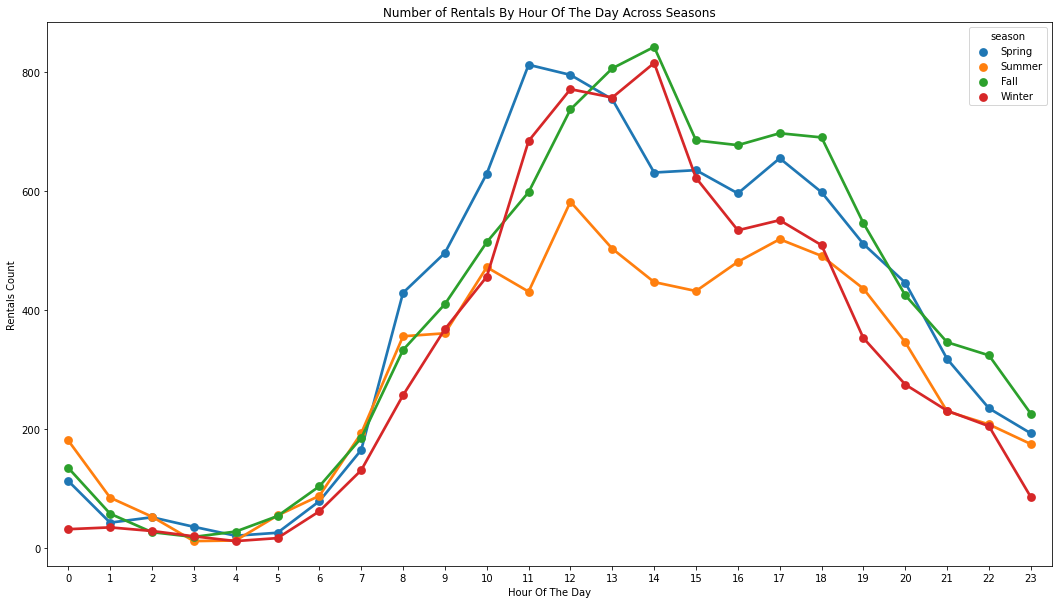

In [63]:
# 0 - Spring | 1 - Summer | 2 - Autumn | 3 - Winter
season_map = {0:'Spring', 1:'Summer', 2:'Fall', 3:'Winter'}
season_freq = hourly_data.groupby(['season', 'rental_hour'])['count'].agg('sum').reset_index(name='count')
season_freq['season'] = season_freq['season'].map(lambda d : season_map[d])
fig, ax = plt.subplots(figsize=(18, 10))
sns.pointplot(x=season_freq["rental_hour"], y=season_freq["count"], hue=season_freq["season"], ax=ax)
ax.set(xlabel='Hour Of The Day', ylabel='Rentals Count', title="Number of Rentals By Hour Of The Day Across Seasons")
plt.show()

### Season

Summer data is low due to the last data collected is August 31st and the summer is yet not finished. **Decided to not use the season as a predictor** for now and after the changing of season the model will be rebuild adding this feature.

### Rentals by Days of the Week

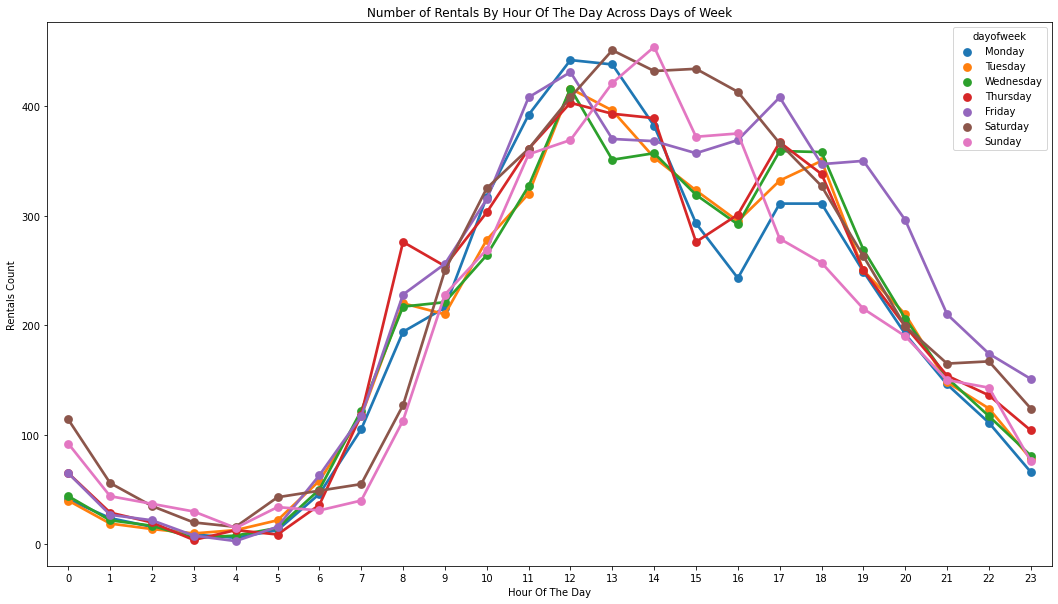

In [64]:
day_of_week_map = {0:'Monday', 1:'Tuesday', 2:'Wednesday', 3:'Thursday', 4:'Friday', 5:'Saturday', 6:'Sunday'}
day_of_week = hourly_data.groupby(['dayofweek', 'rental_hour'])['count'].agg('sum').reset_index(name='count')
day_of_week['dayofweek'] = day_of_week['dayofweek'].map(lambda d : day_of_week_map[d])
fig, ax = plt.subplots(figsize=(18, 10))
sns.pointplot(x=day_of_week["rental_hour"], y=day_of_week["count"], hue=day_of_week["dayofweek"], ax=ax)
ax.set(xlabel='Hour Of The Day', ylabel='Rentals Count', title="Number of Rentals By Hour Of The Day Across Days of Week")
plt.show()

## Battery distribution

In [65]:
battery_dist = all_data.copy()

def group_battery_status(df):

    bins= [0,30,50,80,100]
    labels = ['< 30%','30% - 50%','50% - 80%','> 80%']
    battery_dist['battery_status'] = pd.cut(battery_dist['start_battery'], bins=bins, labels=labels, right=False)

    s = battery_dist.battery_status
    counts = s.value_counts()
    percent = s.value_counts(normalize=True)
    percent100 = s.value_counts(normalize=True).mul(100).round(1).astype(str) + '%'
    
    return pd.DataFrame({'counts': counts, 'per': percent, 'per100': percent100}, labels)

In [66]:
group_battery_status(battery_dist)

,counts,per,per100
< 30%,3495,0.105714,10.6%
30% - 50%,5605,0.169535,17.0%
50% - 80%,13602,0.411421,41.1%
> 80%,10359,0.313330,31.3%


<AxesSubplot:xlabel='start_battery', ylabel='Count'>

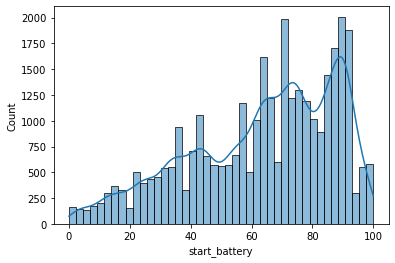

In [67]:
sns.histplot(data=new_rentals, x='start_battery', kde=True)

In [68]:
all_data['duration'].mean()

1035.286579060534

## BoxPlot analysis

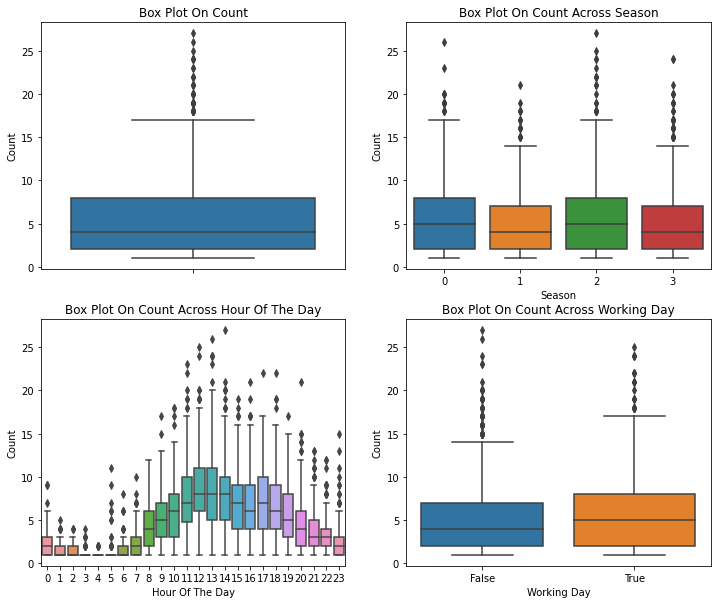

In [117]:
fig, axes = plt.subplots(nrows=2,ncols=2)
fig.set_size_inches(12, 10)
sns.boxplot(data=hourly_data,y="count",orient="v",ax=axes[0][0])
sns.boxplot(data=hourly_data,y="count",x="season",orient="v",ax=axes[0][1])
sns.boxplot(data=hourly_data,y="count",x="rental_hour",orient="v",ax=axes[1][0])
sns.boxplot(data=hourly_data,y="count",x="working_day",orient="v",ax=axes[1][1])

axes[0][0].set(ylabel='Count',title="Box Plot On Count")
axes[0][1].set(xlabel='Season', ylabel='Count',title="Box Plot On Count Across Season")
axes[1][0].set(xlabel='Hour Of The Day', ylabel='Count',title="Box Plot On Count Across Hour Of The Day")
axes[1][1].set(xlabel='Working Day', ylabel='Count',title="Box Plot On Count Across Working Day")

plt.show()

## Correlation Matrix

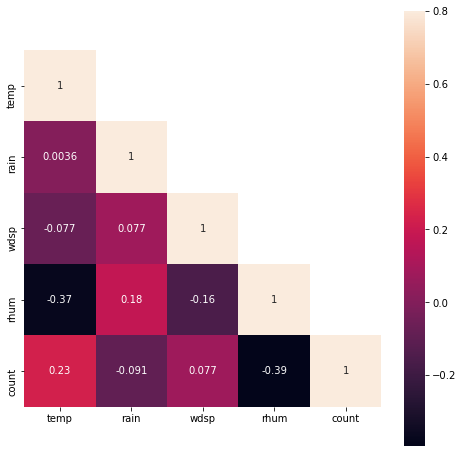

In [118]:
corrMatt = hourly_data[['temp','rain','wdsp','rhum','count']].corr()
mask = np.array(corrMatt)
mask[np.tril_indices_from(mask)] = False
fig,ax= plt.subplots()
fig.set_size_inches(8,8)
sns.heatmap(corrMatt, mask=mask,vmax=.8, square=True,annot=True)
plt.show()

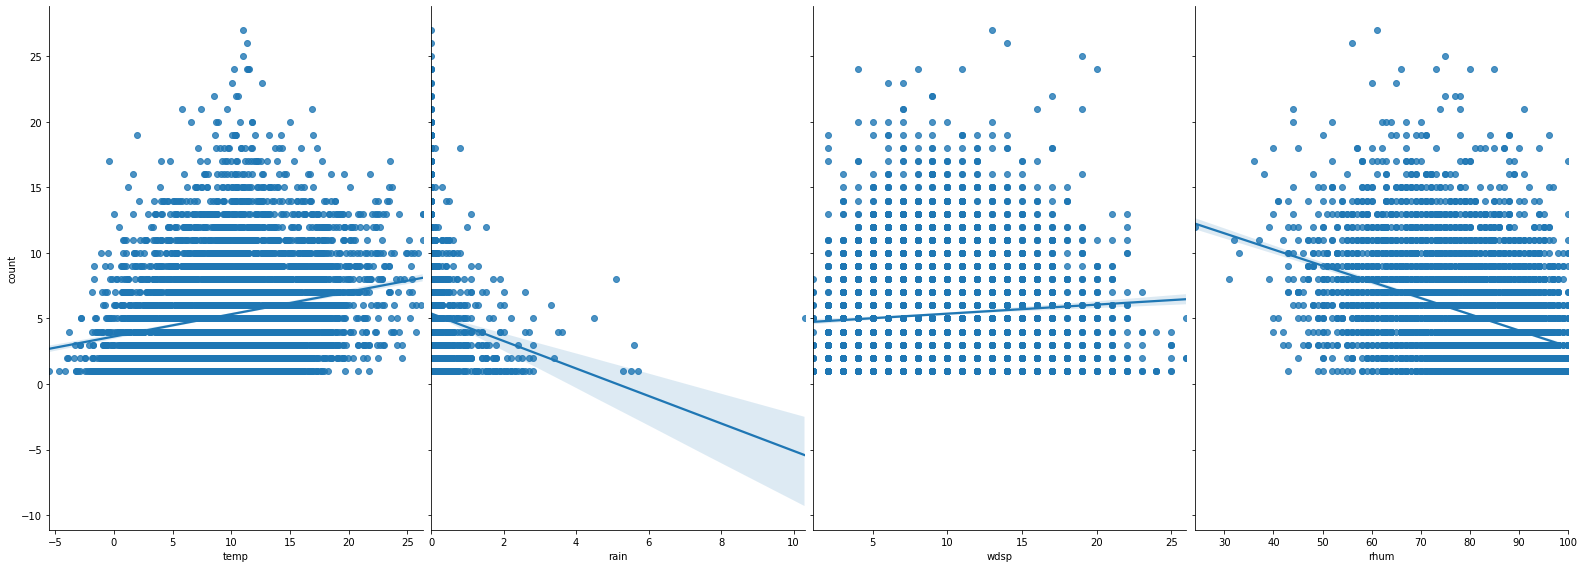

In [134]:
sns.pairplot(hourly_data, x_vars=['temp','rain','wdsp','rhum'], y_vars='count', size=8, aspect=0.7, kind="reg", palette='Set1')
plt.show()

## Distribution of numerical features

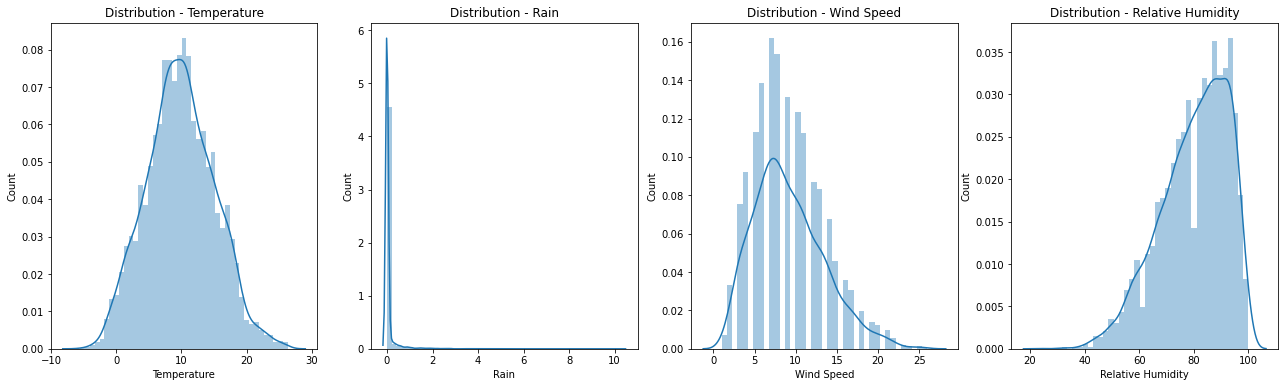

In [120]:
fig = plt.figure(figsize=(22,6))
gs = fig.add_gridspec(1, 4)
ax0 = fig.add_subplot(gs[0, 0])
ax1 = fig.add_subplot(gs[0, 1])
ax2 = fig.add_subplot(gs[0, 2])
ax3 = fig.add_subplot(gs[0, 3])

sns.distplot(hourly_data['temp'],ax=ax0)
sns.distplot(hourly_data['rain'],ax=ax1)
sns.distplot(hourly_data['wdsp'],ax=ax2)
sns.distplot(hourly_data['rhum'],ax=ax3)

ax0.set(xlabel='Temperature',ylabel='Count',title="Distribution - Temperature")
ax1.set(xlabel='Rain', ylabel='Count',title="Distribution - Rain")
ax2.set(xlabel='Wind Speed', ylabel='Count',title="Distribution - Wind Speed")
ax3.set(xlabel='Relative Humidity', ylabel='Count',title="Distribution - Relative Humidity")

plt.show()

In [121]:
normalized_numerical_data = hourly_data.filter(['rain','wdsp','rhum'], axis=1)
scaled_features = StandardScaler().fit_transform(normalized_numerical_data.values)
scaled_features_df = pd.DataFrame(scaled_features, index=normalized_numerical_data.index, columns=normalized_numerical_data.columns)

In [122]:
scaled_features_df.agg(['skew', 'kurtosis']).transpose()

,skew,kurtosis
rain,11.186090,206.190065
wdsp,0.650923,0.227234
rhum,-0.670497,-0.046552


In [123]:
hourly_data.temp.agg(['skew', 'kurtosis']).transpose()

skew        0.125798
kurtosis   -0.211608
Name: temp, dtype: float64

## Log transformation

The logarithmic is a strong transformation that has a major effect on distribution shape. This technique is, as the square root method, oftenly used for reducing right skewness. Worth noting, however, is that it can not be applied to zero or negative values.

## Square Root
The square root method is typically used when your data is moderately skewed. Now using the square root (e.g., sqrt(x)) is  a transformation that has a moderate effect on distribution shape. It is generally used to reduce right skewed data. Finally, the square root can be applied on zero values and is most commonly used on counted data.

## Box Cox Transformation
The Box-Cox transformation is, as you probably understand, also a technique to transform non-normal data into normal shape. This is a procedure to identify a suitable exponent (Lambda = l) to use to transform skewed data.

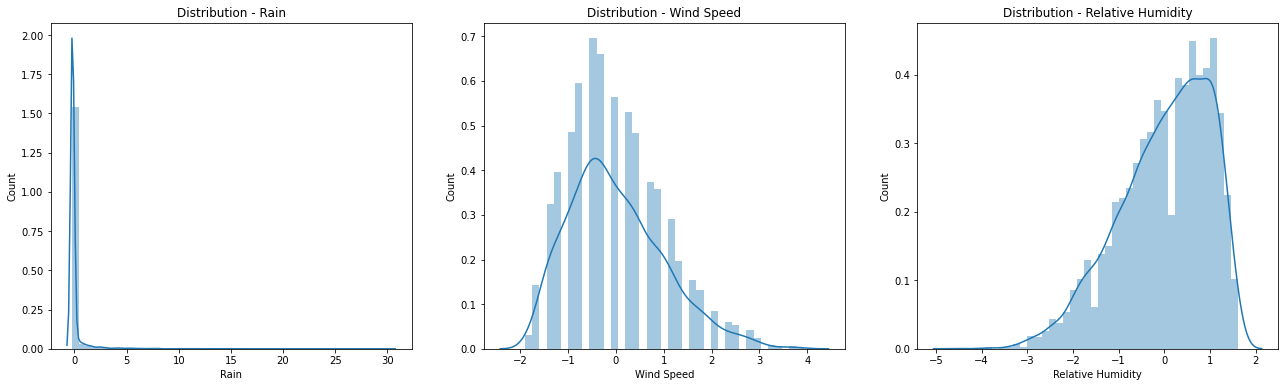

In [124]:
fig = plt.figure(figsize=(22,6))
gs = fig.add_gridspec(1, 3)
ax0 = fig.add_subplot(gs[0, 0])
ax1 = fig.add_subplot(gs[0, 1])
ax2 = fig.add_subplot(gs[0, 2])

sns.distplot(scaled_features_df['rain'],ax=ax0)
sns.distplot(scaled_features_df['wdsp'],ax=ax1)
sns.distplot(scaled_features_df['rhum'],ax=ax2)

ax0.set(xlabel='Rain', ylabel='Count',title="Distribution - Rain")
ax1.set(xlabel='Wind Speed', ylabel='Count',title="Distribution - Wind Speed")
ax2.set(xlabel='Relative Humidity', ylabel='Count',title="Distribution - Relative Humidity")

plt.show()

## Target feature (Count)

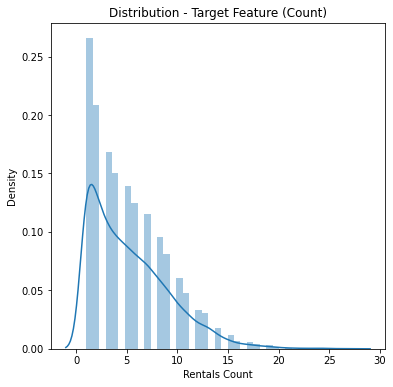

In [126]:
fig, ax = plt.subplots(figsize=(6, 6))
sns.distplot(hourly_data['count'],ax=ax)
ax.set(xlabel='Rentals Count',ylabel='Density',title="Distribution - Target Feature (Count)")
plt.show()

In [ ]:
transform_data = hourly_data.copy()
transform_data['count'] = np.log(transform_data['count'] + 1)
fig, ax = plt.subplots(figsize=(6, 6))
sns.distplot(transform_data['count'],ax=ax)
ax.set(xlabel='Rentals Count',ylabel='Density',title="Distribution - Target Feature (Count)")
plt.show()

## Outliers Analysis

In [ ]:
hourlyDataWithoutOutliers = hourly_data[np.abs(hourly_data["count"]-hourly_data["count"].mean())<=(3*hourly_data["count"].std())] 

In [ ]:
fig, ax = plt.subplots(figsize=(6, 8))
sns.boxplot(data=hourlyDataWithoutOutliers,y="count",orient="v",ax=ax)
ax.set(ylabel='Count',title="Box Plot On Count Withou Outliers")
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(6, 6))
sns.distplot(hourlyDataWithoutOutliers['count'],ax=ax)
ax.set(xlabel='Rentals Count',ylabel='Density',title="Distribution - Target Feature (Without Outliers)")
plt.show()

In [ ]:
print ("Shape of original data: ",hourly_data.shape)
print ("Shape of data without outliers: ",hourlyDataWithoutOutliers.shape)

<a id="4"></a>
# <p style="font-size:100%; text-align:left; color:#444444;">4- Models</p>

## Splitting dataset in train and test

In [ ]:
def adjusted_r2_score(X, r2_score):
    return 1 - ( 1- r2_score ) * ( len(X) - 1 ) / ( len(X) - X.shape[1] - 1 )

In [ ]:
df = hourly_data.copy()
#df = hourlyDataWithoutOutliers.copy()
#df = transform_data.copy()
df = df.astype({'holiday': 'category', 'dayofweek': 'category', 'working_day': 'category', 'peak': 'category'})
predictors = ['rain','temp','wdsp','rhum','holiday','dayofweek','working_day','peak']

X = df[[c for c in df.columns if c in predictors]]
y = df.pop('count')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_train.shape, X_test.shape

## Split columns in categorical and numerical

In [ ]:
num_vars = [c for c in df.select_dtypes(include=['number']).columns if c in predictors] # list comprehension to select only predictors features
cat_vars = df.select_dtypes(include=['category']).columns

## Preprocessing Pipelines

In [ ]:
# Define categorical pipeline
cat_pipe = Pipeline([
    #('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse=False))
])

# Define numerical pipeline
num_pipe = Pipeline([
    #('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
    #('scaler', MinMaxScaler())
])

# Combine categorical and numerical pipelines
preprocessor = ColumnTransformer([
    ('cat', cat_pipe, cat_vars),
    ('num', num_pipe, num_vars)
])

## Feature Importance

In [ ]:
# LightGBM model
params_lightgbm = {'n_estimators': 500, 'boosting_type': 'dart', 'max_depth': 5, 'learning_rate': 0.01, 'subsample': 0.7, 'importance_type': 'gain'}

# Fit a pipeline with transformers and an estimator to the training data
pipe_gbm = Pipeline([
    ('preprocessor', preprocessor),
    ('model', LGBMRegressor(**params_lightgbm))
])
pipe_gbm.fit(X_train, y_train)

In [ ]:
pipe_gbm['model'].feature_importances_

In [ ]:
#Plotting features importance
feature_imp = pd.DataFrame(sorted(zip(pipe_gbm['model'].feature_importances_,X_train.columns)), columns=['Value','Feature'])
scaler_ft = MinMaxScaler()
feature_imp['Value'] = scaler_ft.fit_transform(feature_imp['Value'].values.reshape(-1,1))

fig = plt.figure(figsize=(15, 12))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features Importance')
locs, labels = plt.xticks()
plt.tick_params(axis='both', which='major', labelsize=12)

plt.show()

## Linear Regression

In [ ]:
pipe_linear_regression = Pipeline([
    ('preprocessor', preprocessor),
    ('model', LinearRegression())
])
pipe_linear_regression.fit(X_train, y_train)

# Predict training data
y_train_pred = pipe_linear_regression.predict(X_train)

# Predict test data
y_test_pred = pipe_linear_regression.predict(X_test)

print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_test_pred)))
print('R^2:', metrics.r2_score(y_test, y_test_pred))
print('Adjusted R^2:', adjusted_r2_score(X_test, metrics.r2_score(y_test, y_test_pred)))

# Linear Regression Assumptions

- Linearity
- Normality of the Error
- No Multicollinearity among Predictors
- No Autocorrelation of the Error Terms
- Homoscedasticity

## Testing Linear Regression Assumptions

In [ ]:
def linear_regression_assumptions(features, label, feature_names=None):
    """
    Tests a linear regression on the model to see if assumptions are being met
    
    Source: https://jeffmacaluso.github.io/post/LinearRegressionAssumptions/
    """
    from sklearn.linear_model import LinearRegression
    
    # Setting feature names to x1, x2, x3, etc. if they are not defined
    if feature_names is None:
        feature_names = ['X'+str(feature+1) for feature in range(features.shape[1])]
    
    print('Fitting linear regression')
    # Multi-threading if the dataset is a size where doing so is beneficial
    if features.shape[0] < 100000:
        model = LinearRegression(n_jobs=-1)
    else:
        model = LinearRegression()
        
    model.fit(features, label)
    
    # Returning linear regression R^2 and coefficients before performing diagnostics
    r2 = model.score(features, label)
    print()
    print('R^2:', r2, '\n')
    print('Coefficients')
    print('-------------------------------------')
    print('Intercept:', model.intercept_)
    
    for feature in range(len(model.coef_)):
        print('{0}: {1}'.format(feature_names[feature], model.coef_[feature]))

    print('\nPerforming linear regression assumption testing')
    
    # Creating predictions and calculating residuals for assumption tests
    predictions = model.predict(features)
    df_results = pd.DataFrame({'Actual': label, 'Predicted': predictions})
    df_results['Residuals'] = abs(df_results['Actual']) - abs(df_results['Predicted'])


    def linear_assumption():
        """
        Linearity: Assumes there is a linear relationship between the predictors and
                   the response variable. If not, either a polynomial term or another
                   algorithm should be used.
        """
        print('\n=======================================================================================')
        print('Assumption 1: Linear Relationship between the Target and the Features')
        
        print('Checking with a scatter plot of actual vs. predicted. Predictions should follow the diagonal line.')
        
        # Plotting the actual vs predicted values
        sns.lmplot(x='Actual', y='Predicted', data=df_results, fit_reg=False, size=7)
        
        # Plotting the diagonal line
        line_coords = np.arange(df_results.min().min(), df_results.max().max())
        plt.plot(line_coords, line_coords,  # X and y points
                 color='darkorange', linestyle='--')
        plt.title('Actual vs. Predicted')
        plt.show()
        print('If non-linearity is apparent, consider adding a polynomial term')
        
        
    def normal_errors_assumption(p_value_thresh=0.05):
        """
        Normality: Assumes that the error terms are normally distributed. If they are not,
        nonlinear transformations of variables may solve this.
               
        This assumption being violated primarily causes issues with the confidence intervals
        """
        from statsmodels.stats.diagnostic import normal_ad
        print('\n=======================================================================================')
        print('Assumption 2: The error terms are normally distributed')
        print()
    
        print('Using the Anderson-Darling test for normal distribution')

        # Performing the test on the residuals
        p_value = normal_ad(df_results['Residuals'])[1]
        print('p-value from the test - below 0.05 generally means non-normal:', p_value)
    
        # Reporting the normality of the residuals
        if p_value < p_value_thresh:
            print('Residuals are not normally distributed')
        else:
            print('Residuals are normally distributed')
    
        # Plotting the residuals distribution
        plt.subplots(figsize=(12, 6))
        plt.title('Distribution of Residuals')
        sns.distplot(df_results['Residuals'])
        plt.show()
    
        print()
        if p_value > p_value_thresh:
            print('Assumption satisfied')
        else:
            print('Assumption not satisfied')
            print()
            print('Confidence intervals will likely be affected')
            print('Try performing nonlinear transformations on variables')
        
        
    def multicollinearity_assumption():
        """
        Multicollinearity: Assumes that predictors are not correlated with each other. If there is
                           correlation among the predictors, then either remove prepdictors with high
                           Variance Inflation Factor (VIF) values or perform dimensionality reduction
                           
                           This assumption being violated causes issues with interpretability of the 
                           coefficients and the standard errors of the coefficients.
        """
        from statsmodels.stats.outliers_influence import variance_inflation_factor
        print('\n=======================================================================================')
        print('Assumption 3: Little to no multicollinearity among predictors')
        
        # Plotting the heatmap
        plt.figure(figsize = (10,8))
        sns.heatmap(pd.DataFrame(features, columns=feature_names).corr(), annot=True)
        plt.title('Correlation of Variables')
        plt.show()
        
        print('Variance Inflation Factors (VIF)')
        print('> 10: An indication that multicollinearity may be present')
        print('> 100: Certain multicollinearity among the variables')
        print('-------------------------------------')
       
        # Gathering the VIF for each variable
        VIF = [variance_inflation_factor(features, i) for i in range(features.shape[1])]
        for idx, vif in enumerate(VIF):
            print('{0}: {1}'.format(feature_names[idx], vif))
        
        # Gathering and printing total cases of possible or definite multicollinearity
        possible_multicollinearity = sum([1 for vif in VIF if vif > 10])
        definite_multicollinearity = sum([1 for vif in VIF if vif > 100])
        print()
        print('{0} cases of possible multicollinearity'.format(possible_multicollinearity))
        print('{0} cases of definite multicollinearity'.format(definite_multicollinearity))
        print()

        if definite_multicollinearity == 0:
            if possible_multicollinearity == 0:
                print('Assumption satisfied')
            else:
                print('Assumption possibly satisfied')
                print()
                print('Coefficient interpretability may be problematic')
                print('Consider removing variables with a high Variance Inflation Factor (VIF)')
        else:
            print('Assumption not satisfied')
            print()
            print('Coefficient interpretability will be problematic')
            print('Consider removing variables with a high Variance Inflation Factor (VIF)')
        
        
    def autocorrelation_assumption():
        """
        Autocorrelation: Assumes that there is no autocorrelation in the residuals. If there is
                         autocorrelation, then there is a pattern that is not explained due to
                         the current value being dependent on the previous value.
                         This may be resolved by adding a lag variable of either the dependent
                         variable or some of the predictors.
        """
        from statsmodels.stats.stattools import durbin_watson
        print('\n=======================================================================================')
        print('Assumption 4: No Autocorrelation')
        print('\nPerforming Durbin-Watson Test')
        print('Values of 1.5 < d < 2.5 generally show that there is no autocorrelation in the data')
        print('0 to 2< is positive autocorrelation')
        print('>2 to 4 is negative autocorrelation')
        print('-------------------------------------')
        durbinWatson = durbin_watson(df_results['Residuals'])
        print('Durbin-Watson:', durbinWatson)
        if durbinWatson < 1.5:
            print('Signs of positive autocorrelation', '\n')
            print('Assumption not satisfied', '\n')
            print('Consider adding lag variables')
        elif durbinWatson > 2.5:
            print('Signs of negative autocorrelation', '\n')
            print('Assumption not satisfied', '\n')
            print('Consider adding lag variables')
        else:
            print('Little to no autocorrelation', '\n')
            print('Assumption satisfied')

            
    def homoscedasticity_assumption():
        """
        Homoscedasticity: Assumes that the errors exhibit constant variance
        """
        print('\n=======================================================================================')
        print('Assumption 5: Homoscedasticity of Error Terms')
        print('Residuals should have relative constant variance')
        
        # Plotting the residuals
        plt.subplots(figsize=(12, 6))
        ax = plt.subplot(111)  # To remove spines
        plt.scatter(x=df_results.index, y=df_results.Residuals, alpha=0.5)
        plt.plot(np.repeat(0, df_results.index.max()), color='darkorange', linestyle='--')
        ax.spines['right'].set_visible(False)  # Removing the right spine
        ax.spines['top'].set_visible(False)  # Removing the top spine
        plt.title('Residuals')
        plt.show() 
        print('If heteroscedasticity is apparent, confidence intervals and predictions will be affected')
        
        
    linear_assumption()
    normal_errors_assumption()
    multicollinearity_assumption()
    autocorrelation_assumption()
    homoscedasticity_assumption()

## Ridge Regression

[Ridge](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html#sklearn.linear_model.Ridge) regression addresses some of the problems of Ordinary Least Squares by imposing a penalty on the size of the coefficients with l2 regularization.

In [ ]:
# Fit a pipeline with transformers and an estimator to the training data
pipe_ridge = Pipeline([
    ('preprocessor', preprocessor),
    ('model', Ridge())
])
pipe_ridge.fit(X_train, y_train)

y_train_pred = pipe_ridge.predict(X_train)
y_test_pred = pipe_ridge.predict(X_test)

print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_test_pred)))
print('R^2:', metrics.r2_score(y_test, y_test_pred))
print('Adjusted R^2:', adjusted_r2_score(X_test, metrics.r2_score(y_test, y_test_pred)))

## Lasso Regression

The [Lasso](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html#sklearn.linear_model.Lasso) is a linear model that estimates sparse coefficients with l1 regularization.

In [ ]:
# Fit a pipeline with transformers and an estimator to the training data
pipe_lasso = Pipeline([
    ('preprocessor', preprocessor),
    ('model', linear_model.Lasso(alpha=0.1))
])
pipe_lasso.fit(X_train, y_train)
y_train_pred = pipe_lasso.predict(X_train)
y_test_pred = pipe_lasso.predict(X_test)

print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_test_pred)))
print('R^2:', metrics.r2_score(y_test, y_test_pred))
print('Adjusted R^2:', adjusted_r2_score(X_test, metrics.r2_score(y_test, y_test_pred)))

## Elastic-Net

[Elastic-Net](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNet.html#sklearn.linear_model.ElasticNet) is a linear regression model trained with both l1 and l2 -norm regularization of the coefficients.

In [ ]:
# Fit a pipeline with transformers and an estimator to the training data
pipe_elastic = Pipeline([
    ('preprocessor', preprocessor),
    ('model', ElasticNet())
])
pipe_elastic.fit(X_train, y_train)
y_train_pred = pipe_elastic.predict(X_train)
y_test_pred = pipe_elastic.predict(X_test)

print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_test_pred)))
print('R^2:', metrics.r2_score(y_test, y_test_pred))
print('Adjusted R^2:', adjusted_r2_score(X_test, metrics.r2_score(y_test, y_test_pred)))

## Random Forest Regressor

In [ ]:
# random forest model
params_rf = {'n_estimators': 1000, 'max_depth': 15, 'random_state': 0, 'min_samples_split' : 5, 'n_jobs': -1}

# Fit a pipeline with transformers and an estimator to the training data
pipe_rf = Pipeline([
    ('preprocessor', preprocessor),
    ('model', RandomForestRegressor(**params_rf))
])
pipe_rf.fit(X_train, y_train)
y_train_pred = pipe_rf.predict(X_train)
y_test_pred = pipe_rf.predict(X_test)

print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_test_pred)))
print('R^2:', metrics.r2_score(y_test, y_test_pred))
print('Adjusted R^2:', adjusted_r2_score(X_test, metrics.r2_score(y_test, y_test_pred)))

## GradientBoost

In [ ]:
# GBM model
params_gbm = {'n_estimators': 150, 'max_depth': 5, 'random_state': 0, 'min_samples_leaf' : 10, 'learning_rate': 0.01, 'subsample': 0.7, 'loss': 'ls'}

# Fit a pipeline with transformers and an estimator to the training data
pipe_gbm = Pipeline([
    ('preprocessor', preprocessor),
    ('model', GradientBoostingRegressor(**params_gbm))
])
pipe_gbm.fit(X_train, y_train)
y_train_pred = pipe_gbm.predict(X_train)
y_test_pred = pipe_gbm.predict(X_test)

print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_test_pred)))
print('R^2:', metrics.r2_score(y_test, y_test_pred))
print('Adjusted R^2:', adjusted_r2_score(X_test, metrics.r2_score(y_test, y_test_pred)))

## LightGBM

In [ ]:
# LightGBM model
params_lightgbm = {'n_estimators': 150, 'max_depth': 5, 'random_state': 0, 'learning_rate': 0.01, 'subsample': 0.7}

# Fit a pipeline with transformers and an estimator to the training data
pipe_gbm = Pipeline([
    ('preprocessor', preprocessor),
    ('model', LGBMRegressor(**params_lightgbm))
])
pipe_gbm.fit(X_train, y_train)
y_train_pred = pipe_gbm.predict(X_train)
y_test_pred = pipe_gbm.predict(X_test)

print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_test_pred)))
print('R^2:', metrics.r2_score(y_test, y_test_pred))
print('Adjusted R^2:', adjusted_r2_score(X_test, metrics.r2_score(y_test, y_test_pred)))

## Catboost

In [ ]:
# Catboost model

# Fit a pipeline with transformers and an estimator to the training data
pipe_catboost = Pipeline([
    ('preprocessor', preprocessor),
    ('model', CatBoostRegressor(verbose=0, n_estimators=100))
])
pipe_catboost.fit(X_train, y_train)
y_train_pred = pipe_catboost.predict(X_train)
y_test_pred = pipe_catboost.predict(X_test)

print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_test_pred)))
print('R^2:', metrics.r2_score(y_test, y_test_pred))
print('Adjusted R^2:', adjusted_r2_score(X_test, metrics.r2_score(y_test, y_test_pred)))

<img title="GitHub Mark" src="./img/GitHub-Mark-64px.png" style="height: 32px; padding-right: 15px" alt="GitHub Mark" align="left"> [GitHub repository](https://github.com/pessini/moby-bikes) <br>Author: Leandro Pessini